<a href="https://colab.research.google.com/github/jads-nl/execute-nhs-proms/blob/master/notebooks/4.0-modeling-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background to osteoarthritis case study

This is day 4 from the [5-day JADS NHS PROMs data science case study](https://github.com/jads-nl/execute-nhs-proms/blob/master/README.md). To recap the previous lectures:

- In **lecture 1** we focused on data understanding and explored various possible outcome parameters.
- In **lecture 2** we constructed a combined outcome parameter using cut-off points for pain and physical functioning.
- In **lecture 3** we performed regression and linear modeling on the outcome paramter `t1_eq_vas`.

Today we are going to focus on classifcation.

# Modeling: clustering & classfication

## Learning objectives
### Modeling: classification

Recall we defined different outcome Y suitable for classification in lecture 2:

- `y_mcid`: outcome is good (True/1) if `t1_oks_score` is above the threshold or `delta_oks_score` is larger than MCID
- `y_t1_pain_good` and `y_t1_functioning_good`: combination of two binary outcomes, yielding a total of 4 classes.

We will use the second outcome since it is more challenging and versatile (see [this presentation (in Dutch)](https://kapitan.net/wp-content/uploads/2018/11/181108_data_driven_healthcare_congres.pdf) for more details):
- perform a binary classification, defining good outcome where both pain and functioning is good at `t1`
- perform multiclass classification.

We will compare the performance of single estimators (SVM, Decision tree) with ensemble learning (Random Forest, Gradient Boosting). Grid search and cross validation is done for model assessment. Some examples are given to visualize scoring functions of models to aid in model selection.


### Python: Hands-on Machine Learning (2nd edition)

- [Classification (chapter 3)](https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb)
- [Support-vector machines (chapter 5)](https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb)
- [Decision trees (chapter 6)](https://github.com/ageron/handson-ml2/blob/master/06_decision_trees.ipynb)
- [Ensemble learning and random forests (chapter 7)](https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb)

### Python: scikit-learn and matplotlib
- [Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py)
- [Visualizations](https://scikit-learn.org/stable/visualizations.html#visualizations)
- [Real Python Matplotlib guide](https://realpython.com/python-matplotlib-guide/)
- [Matplotlib anatomy](https://matplotlib.org/3.2.2/gallery/showcase/anatomy.html)
- [Yellowbrick](https://www.slideshare.net/RebeccaBilbro/learning-machine-learning-with-yellowbrick)

Let's start by re-running the relevant code from previous lectures, after which we can continue extending our pipelines to experiment with different classifiers.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit

#supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

# pandas options
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

# read data
df = pd.read_parquet('https://github.com/jads-nl/execute-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

In [2]:
# handy function to select oks columns
def oks_questions(t='t0'):
  return [
    col for col in df.columns if col.startswith(f"oks_{t}") and not col.endswith("_score")
]

# replace sentinel values in oks columns
# note we are doing imputation on original dataframe (rather than in pipeline later on)
# so we can perform it prior to StratefiedShuffleSplit
oks_no9 = oks_questions('t0') + oks_questions('t1')
impute_oks = SimpleImputer(missing_values=9, strategy="most_frequent")
df.loc[:, oks_no9] = impute_oks.fit_transform(df[oks_no9])

# group columns t0
age_band = ["age_band"]
gender = ["gender"]
age_band_categories = sorted([x for x in df.age_band.unique() if isinstance(x, str)])
comorb = [
    "heart_disease",
    "high_bp",
    "stroke",
    "circulation",
    "lung_disease",
    "diabetes",
    "kidney_disease",
    "nervous_system",
    "liver_disease",
    "cancer",
    "depression",
    "arthritis",
]
boolean = ["t0_assisted", "t0_previous_surgery", "t0_disability"]
eq5d = ["t0_mobility", "t0_self_care", "t0_activity", "t0_discomfort", "t0_anxiety"]
eq_vas = ["t0_eq_vas"]
categorical = ["t0_symptom_period", "t0_previous_surgery", "t0_living_arrangements"]
oks_score = ["oks_t0_score"]

# add number of comorbidities as extra feature
impute_comorb = SimpleImputer(missing_values=9, strategy="constant", fill_value=0)
df.loc[:, comorb] = impute_comorb.fit_transform(df[comorb])
df["n_comorb"] = df.loc[:, comorb].sum()


# define outcome Y
CUT_OFF_PAIN = 4
CUT_OFF_FUNCTIONING = 26

for t in ("t0", "t1"):
    df[f"oks_{t}_pain_total"] = df[f"oks_{t}_pain"] + df[f"oks_{t}_night_pain"]
    df[f"oks_{t}_functioning_total"] = (
        df.loc[:, [col for col in oks_questions(t) if "pain" not in col]]
        .sum(axis=1)
    )
    df[f"y_{t}_pain_good"] = df[f"oks_{t}_pain_total"].apply(
        lambda s: True if s >= CUT_OFF_PAIN else False
    )
    df[f"y_{t}_functioning_good"] = df[f"oks_{t}_functioning_total"].apply(
        lambda s: True if s >= CUT_OFF_FUNCTIONING else False
    )

# define binary outcome parameter
df["y_binary"] = np.logical_and(df.y_t1_pain_good, df.y_t1_functioning_good)

# Only using 1 split for stratefied sampling, more folds are used later on in cross-validation
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df["y_binary"]):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]
    
y_train_pain_good = df_train.y_t1_pain_good
y_train_pain_good = df_train.y_t1_functioning_good
y_train_binary = df_train.y_binary

y_test_pain_good = df_test.y_t1_pain_good
y_test_pain_good = df_test.y_t1_functioning_good
y_test_binary = df_test.y_binary

In [3]:
y0 = pd.crosstab(df_train.y_t0_pain_good, df_train.y_t0_functioning_good, normalize=True)
y0

y_t0_functioning_good,False,True
y_t0_pain_good,,
False,0.81,0.07
True,0.08,0.05


In [4]:
y1 = pd.crosstab(df_train.y_t1_pain_good, df_train.y_t1_functioning_good, normalize=True)
y1

y_t1_functioning_good,False,True
y_t1_pain_good,,
False,0.15,0.06
True,0.08,0.71


In [5]:
# same pipeline as lecture 3
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer


# preprocessing pipelines for specific columns
age_band_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=None, strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(categories=[age_band_categories])),
    ]
)
gender_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

# ColumnTransformer on all included columns.
# Note columns that are not specified are dropped by default
transformers = {
    "age": ("age", age_band_pipe, age_band),
    "gender": ("gender", gender_pipe, gender),
    "comorb": (
        "comorb",
        'passthrough',
        comorb,
    ),
    "categorical": (
        "categorical",
        SimpleImputer(missing_values=9, strategy="most_frequent"),
        boolean + eq5d + categorical,
    ),
    "oks": (
        "oks",
        'passthrough',
        oks_questions('t0'),
    ),
    "eq_vas": ("eqvas", SimpleImputer(missing_values=999, strategy="median"), eq_vas),
}
prep = ColumnTransformer(
    transformers=[v for _, v in transformers.items()])

In [6]:
# list of columns for convenience
# https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-name-after-onehotencode-in-columntransformer
X_train = prep.fit_transform(df_train)
X_test = prep.fit_transform(df_test)
X_columns = pd.Series(
    age_band
    + prep.named_transformers_["gender"]["onehot"].get_feature_names().tolist()
    + comorb
    + boolean
    + eq5d
    + categorical
    + oks_questions()
    + oks_score
    + eq_vas
)

In [7]:
X_columns

0                     age_band
1                       x0_1.0
2                       x0_2.0
3                heart_disease
4                      high_bp
5                       stroke
6                  circulation
7                 lung_disease
8                     diabetes
9               kidney_disease
10              nervous_system
11               liver_disease
12                      cancer
13                  depression
14                   arthritis
15                 t0_assisted
16         t0_previous_surgery
17               t0_disability
18                 t0_mobility
19                t0_self_care
20                 t0_activity
21               t0_discomfort
22                  t0_anxiety
23           t0_symptom_period
24         t0_previous_surgery
25      t0_living_arrangements
26                 oks_t0_pain
27           oks_t0_night_pain
28              oks_t0_washing
29            oks_t0_transport
30              oks_t0_walking
31             oks_t0_standing
32      

## Classification


### Data mining goals
Recall from our earlier discussions (phase 1: Business Understanding) that we want to predict the outcome of surgery. To make this more explicit, for now we choose to predict the outcome being in the bottom-right quadrant of `y1` i.e. with good functioning and less pain. The base-rate `P / (P + N) = 71%`. 

### Single estimators: Stochastic Gradient Decent, Decision Tree (CART) and SVM
#### Stochastic Gradient Descent

In [8]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


sgd = Pipeline(
    steps=[("prep", prep), ("sgd", SGDClassifier(loss="hinge", penalty="l2", tol=1e-3))]
)

# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
sgd_parameters = {"sgd__max_iter": [10]} #, 100, 1000]}

sgd_search = GridSearchCV(sgd, sgd_parameters, cv=5)
_ = sgd_search.fit(df_train, y_train_binary)  # assign output of fit to dummy parameter to prevent printing in notebook

CPU times: user 17.5 s, sys: 2.97 s, total: 20.4 s
Wall time: 19.8 s


In [ ]:
confusion_matrix(y_train_binary, sgd_search.best_estimator_.predict(df_train), normalize='all').round(3)

array([[0.259, 0.034],
       [0.513, 0.195]])

In [ ]:
cross_val_score(sgd_search.best_estimator_, df_train, y_train_binary, cv=3, scoring="roc_auc").round(3)

array([0.599, 0.696, 0.628])

#### Decision Tree (CART)

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier

cart = Pipeline(
    steps=[
        ("prep", prep),
        ("cart", DecisionTreeClassifier()),
    ]
)

cart_parameters = {
'cart__max_depth': [10, 30],
'cart__min_samples_leaf': [0.02, 0.05, 0.1, 0.2],
}

cart_search = GridSearchCV(cart, cart_parameters, cv=5)
_ = cart_search.fit(df_train, y_train_binary);

CPU times: user 1min 3s, sys: 5.3 s, total: 1min 9s
Wall time: 1min 11s


In [ ]:
confusion_matrix(y_train_binary, cart_search.best_estimator_.predict(df_train), normalize='all').round(3)

array([[0.059, 0.234],
       [0.04 , 0.668]])

In [ ]:
cross_val_score(cart_search.best_estimator_, df_train, y_train_binary, cv=3, scoring="roc_auc").round(3)

array([0.686, 0.69 , 0.681])

#### LinearSVC  

In [ ]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

svm = Pipeline(
    steps=[
        ("prep", prep),
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(C=1, loss="hinge")),
    ]
)
_ = svm.fit(df_train, y_train_binary);

CPU times: user 28.7 s, sys: 973 ms, total: 29.7 s
Wall time: 31.2 s


In [ ]:
confusion_matrix(y_train_binary, svm.predict(df_train), normalize='all').round(3)

array([[0.028, 0.265],
       [0.028, 0.679]])

In [ ]:
cross_val_score(svm, df_train, y_train_binary, cv=3, scoring="roc_auc").round(3)

array([0.521, 0.591, 0.636])

#### ROC curve
It is more intuitive to compare different estimators visually, i.e. visualizing the performance metrics. scikit-learn 0.22 comes with a [new plotting API](https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_0_22_0.html#sphx-glr-auto-examples-release-highlights-plot-release-highlights-0-22-0-py), so it's much easier than before to quickly produce charts. We start with the good ol' ROC curve (although later on I will stress not to use this!).

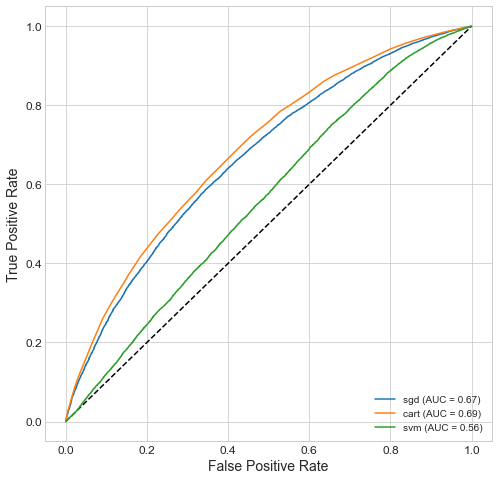

In [ ]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

clfs = {
    "sgd": sgd_search.best_estimator_,
    "cart": cart_search.best_estimator_,
    "svm": svm,
}

fig_roc, ax_roc = plt.subplots(figsize=S)
plt.plot([0, 1], [0, 1], 'k--')
for k,v in clfs.items():
    plot_roc_curve(v, df_test, y_test_binary, name=k, ax=ax_roc);

#### PR curve
The results from the ROC curve are not very exciting. Let's look at the precision recall curve.

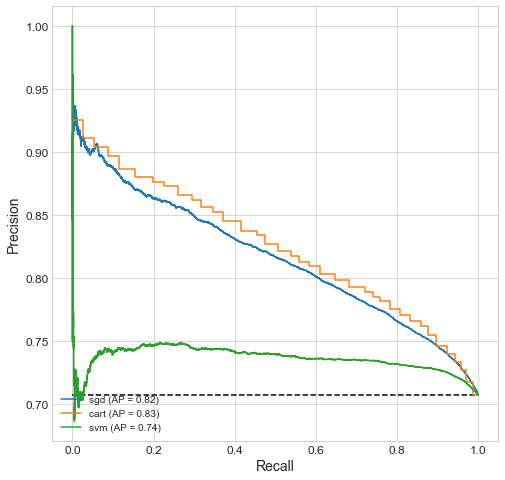

In [ ]:
fig_prc, ax_prc = plt.subplots(figsize=S)
plt.plot([0,1], [ y1.iloc[1,1],  y1.iloc[1,1]], 'k--')
for k,v in clfs.items():
    plot_precision_recall_curve(v, df_test, y_test_binary, name=k, ax=ax_prc)

### Ensemble methods: Random Forest & GradientBoosted Trees

We are going to do the same - train classifiers with grid search and cross-validation - but using an ensemble of learners this time.

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier


rf = Pipeline(
    steps=[("prep", prep), ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))]
)
rf_parameters = {
    "rf__max_samples": [1000],  # don't use the whole dataset: takes too long!
    "rf__n_estimators": [100],
    "rf__criterion": ["gini"],
    "rf__max_features": ["auto"],
    "rf__min_samples_leaf": [1, 2, 5],
    "rf__max_depth": [10, 15],
    "rf__oob_score": [True, False],
}
rf_search = GridSearchCV(rf, rf_parameters, cv=5)
_ = rf_search.fit(df_train, y_train_binary)

CPU times: user 2min 39s, sys: 14.5 s, total: 2min 53s
Wall time: 3min 6s


In [ ]:
# take very long, so not run

# %%time
# from sklearn.ensemble import GradientBoostingClassifier

# gb = Pipeline(
#     steps=[("prep", prep), ("gb", GradientBoostingClassifier())]
# )
# gb_parameters = {
#     "gb__learning_rate": [1.0],
#     "gb__n_estimators": [100, 200],
#     "gb__min_samples_leaf": [1, 2, 5],
#     "gb__max_features": ["auto"],
#     "gb__max_depth": [2, 3, 5],
# }
# gb_search = GridSearchCV(gb, gb_parameters, cv=5)
# _ = gb_search.fit(df_train, y_train_binary)

#### XGBoost

The GradientBoostingClassifier in sklearn is quite slow. [XGboost](https://xgboost.readthedocs.io/en/latest/index.html) is a better and faster implementation. After installing it separately, you can use the sklearn API to use it in our existing pipeline.

In [ ]:
%%time
import xgboost

xgb = Pipeline(steps=[("prep", prep), ("xgb", xgboost.XGBClassifier(random_state=42))])
_ = xgb.fit(df_train, y_train_binary)

CPU times: user 47.1 s, sys: 1.03 s, total: 48.2 s
Wall time: 9.57 s


In [ ]:
confusion_matrix(y_train_binary, xgb.predict(df_train), normalize='all').round(3)

array([[0.097, 0.196],
       [0.039, 0.668]])

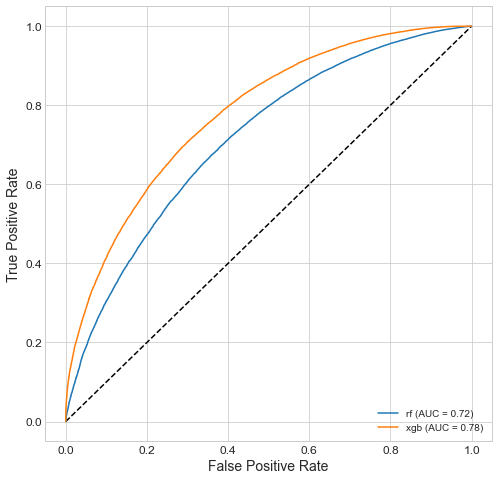

In [ ]:
ensembles = {
    "rf": rf_search.best_estimator_,
#     "gb": gb_search.best_estimator_,
    "xgb": xgb,
}

fig_roc2, ax_roc2 = plt.subplots(figsize=S)
plt.plot([0, 1], [0, 1], 'k--')
for k,v in ensembles.items():
    plot_roc_curve(v, df_train, y_train_binary, name=k, ax=ax_roc2)

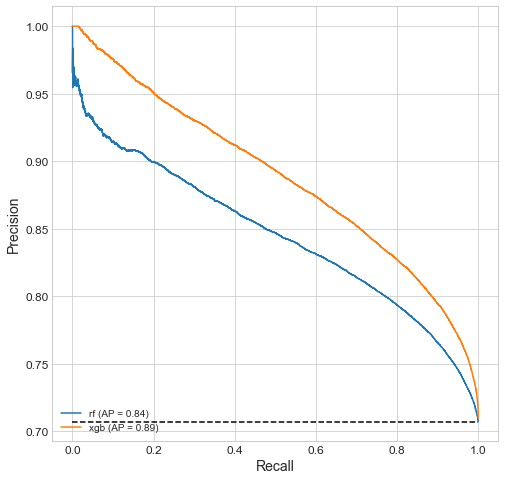

In [ ]:
fig_prc2, ax_prc2 = plt.subplots(figsize=S)
plt.plot([0, 1], [y1.iloc[1,1], y1.iloc[1,1]], 'k--')
for k,v in ensembles.items():
    plot_precision_recall_curve(v, df_train, y_train_binary, name=k, ax=ax_prc2)

But hang on, don't get too excited yet: aren't we overfitting?

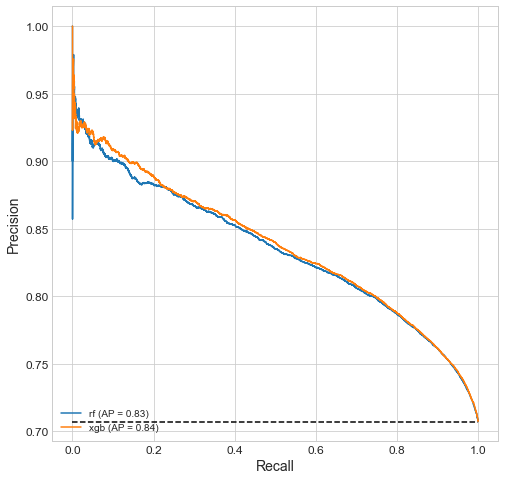

In [ ]:
fig_prc2a, ax_prc2a = plt.subplots(figsize=S)
plt.plot([0, 1], [y1.iloc[1,1], y1.iloc[1,1]], 'k--')
for k,v in ensembles.items():
    plot_precision_recall_curve(v, df_test, y_test_binary, name=k, ax=ax_prc2a)

#### Ensemble methods: balanced
The results are better than single estimators, but can we make it better still? We will try balanced Random Forest, using the `class_weight` option in scikit-learn and comparing that next to the `BalancedRandomForestClassifier` from the [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/) package.

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier


brf = Pipeline(
    steps=[("prep", prep), ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))]
)
brf_parameters = {
    "rf__max_samples": [1000],  # don't use the whole dataset: takes too long!
    "rf__n_estimators": [100],
    "rf__criterion": ["gini"],
    "rf__max_features": ["auto"],
    "rf__min_samples_leaf": [1, 2, 5],
    "rf__max_depth": [10, 15],
    "rf__oob_score": [True, False],
    "rf__class_weight": ["balanced"],
}
brf_search = GridSearchCV(brf, brf_parameters, cv=5)
_ = brf_search.fit(df_train, y_train_binary)

CPU times: user 2min 40s, sys: 15.1 s, total: 2min 55s
Wall time: 3min 11s


In [ ]:
%%time
from imblearn.ensemble import BalancedRandomForestClassifier


ibrf = Pipeline(
    steps=[("prep", prep), ("rf", BalancedRandomForestClassifier(random_state=42, n_jobs=-1))]
)
ibrf_parameters = {
    "rf__max_samples": [1000],  # don't use the whole dataset: takes too long!
    "rf__n_estimators": [100],
    "rf__criterion": ["gini"],
    "rf__max_features": ["auto"],
    "rf__min_samples_leaf": [1, 2, 5],
    "rf__max_depth": [10, 15],
    "rf__oob_score": [True, False],
}
ibrf_search = GridSearchCV(ibrf, ibrf_parameters, cv=5)
_ = ibrf_search.fit(df_train, y_train_binary)

CPU times: user 2min 54s, sys: 27 s, total: 3min 21s
Wall time: 4min 14s


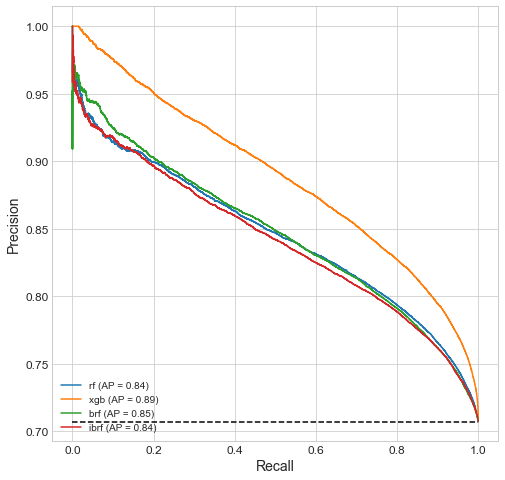

In [ ]:
ensembles["brf"] = brf_search.best_estimator_
ensembles["ibrf"] = ibrf_search.best_estimator_

fig_prc3, ax_prc3 = plt.subplots(figsize=S)
plt.plot([0, 1], [y1.iloc[1,1], y1.iloc[1,1]], 'k--')
for k,v in ensembles.items():
    plot_precision_recall_curve(v, df_train, y_train_binary, name=k, ax=ax_prc3);

#### Try the inverse: predicting patients with not in good-good quadrant

In [ ]:
%%time
# see what performance is for outlier detection
y_train_binary_inverted = np.invert(y_train_binary)

xgb_inv = Pipeline(steps=[("prep", prep), ("xgb", xgboost.XGBClassifier())])
_ = xgb_inv.fit(df_train, y_train_binary_inverted)

CPU times: user 46.8 s, sys: 1.12 s, total: 47.9 s
Wall time: 10.2 s


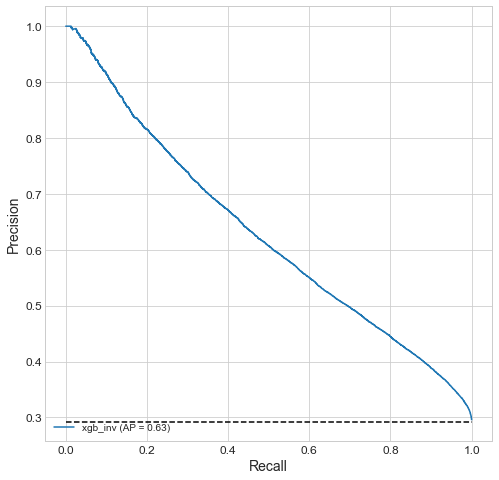

In [ ]:
fig_prc4, ax_prc4 = plt.subplots(figsize=S)
plt.plot([0, 1], [1 - y1.iloc[1,1], 1 - y1.iloc[1,1]], 'k--')
plot_precision_recall_curve(xgb_inv, df_train, y_train_binary_inverted, name="xgb_inv", ax=ax_prc4);

Clearly more difficult to detect 'outliers' i.e. patients with less than optimal outcome.

#### Bonus: Yellowbrick
To further optimze your workflow, you can use [Yellowbrick](https://www.scikit-yb.org/en/latest/index.html) for visualizing results.

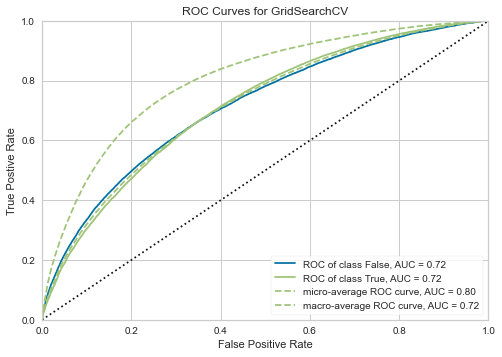

In [ ]:
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

roc = ROCAUC(rf_search,)
roc.fit(df_train, y_train_binary)
roc.score(df_train, y_train_binary)
roc.show();

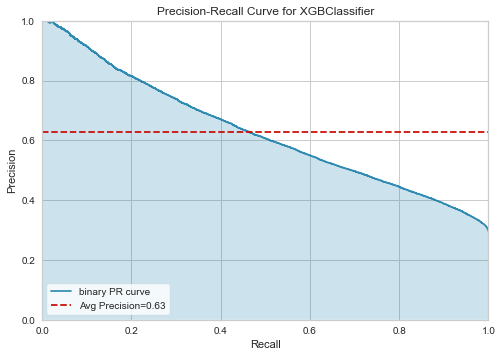

In [ ]:
prc = PrecisionRecallCurve(xgb_inv,)
prc.fit(df_train, y_train_binary_inverted)
prc.score(df_train, y_train_binary_inverted)
prc.show();

## Discussion: model assessment and evaluation

### Greediness of algorithms

Even if you have a good result, i.e. a good score with the test set, you should beware of the greediness of machine learning algorithms: the solution is _at best_ a local optimum, and sometimes not even that. Depending on the random state at initiazation, the results will vary. To illustrate this, let's do 5 runs of XBGBoost (being the best model we have looked at) with different random states.


In [ ]:
runs = [{"random_state": n} for n in range(2, 52, 10)]
for run in runs:
    xgb = Pipeline(steps=[("prep", prep), ("xgb", xgboost.XGBClassifier(random_state=run['random_state'], subsample=0.7))])
    run["model"] = xgb.fit(df_train, y_train_binary)

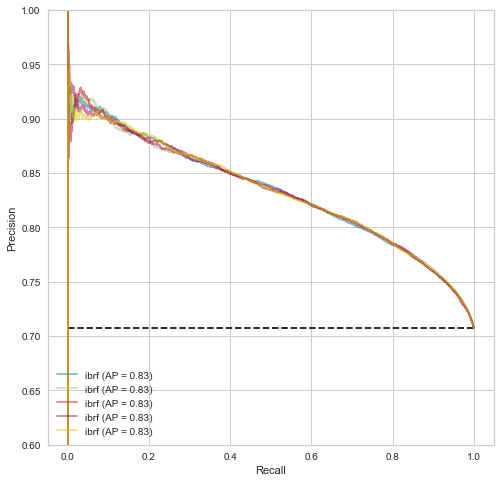

In [ ]:
fig_random, ax_random = plt.subplots(figsize=S)
ax_random.set_ylim(0.6, 1.0)
plt.plot([0, 1], [y1.iloc[1,1], y1.iloc[1,1]], 'k--')
for run in runs:
    plot_precision_recall_curve(run['model'], df_test, y_test_binary, name=k, ax=ax_random, alpha=0.5)

### Feature importance

Many tree-based methods can compute feature importance. Also here, note that this is a relative importance and that due to the greediness you can not draw very hard conclusions (features by swap places depending on the parameter settings). It is useful to get an intuitive feel which features contain the most information for your classification task.

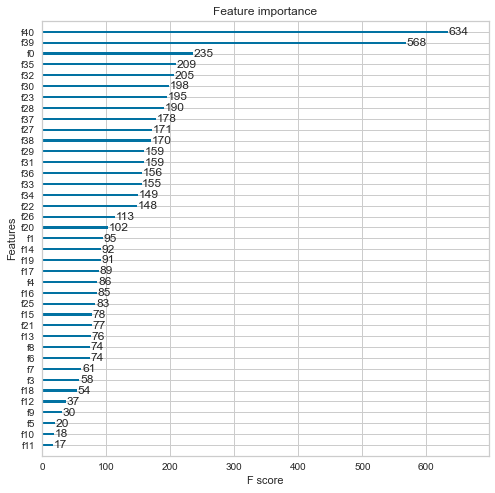

In [ ]:
fig_importance, ax_importance = plt.subplots(figsize=S)
xgboost.plot_importance(xgb['xgb'], ax=ax_importance);

In [ ]:
# To DO: fix feature names in plot
list(zip(xgb['xgb'].get_booster().feature_names, X_columns))

[('f0', 'age_band'),
 ('f1', 'x0_1.0'),
 ('f2', 'x0_2.0'),
 ('f3', 'heart_disease'),
 ('f4', 'high_bp'),
 ('f5', 'stroke'),
 ('f6', 'circulation'),
 ('f7', 'lung_disease'),
 ('f8', 'diabetes'),
 ('f9', 'kidney_disease'),
 ('f10', 'nervous_system'),
 ('f11', 'liver_disease'),
 ('f12', 'cancer'),
 ('f13', 'depression'),
 ('f14', 'arthritis'),
 ('f15', 't0_assisted'),
 ('f16', 't0_previous_surgery'),
 ('f17', 't0_disability'),
 ('f18', 't0_mobility'),
 ('f19', 't0_self_care'),
 ('f20', 't0_activity'),
 ('f21', 't0_discomfort'),
 ('f22', 't0_anxiety'),
 ('f23', 't0_symptom_period'),
 ('f24', 't0_previous_surgery'),
 ('f25', 't0_living_arrangements'),
 ('f26', 'oks_t0_pain'),
 ('f27', 'oks_t0_night_pain'),
 ('f28', 'oks_t0_washing'),
 ('f29', 'oks_t0_transport'),
 ('f30', 'oks_t0_walking'),
 ('f31', 'oks_t0_standing'),
 ('f32', 'oks_t0_limping'),
 ('f33', 'oks_t0_kneeling'),
 ('f34', 'oks_t0_work'),
 ('f35', 'oks_t0_confidence'),
 ('f36', 'oks_t0_shopping'),
 ('f37', 'oks_t0_stairs'),
 ('f3

### Bias-variance trade-off

One of the nice features of XGBoost is that it has [explicitly defined the complexity function](https://xgboost.readthedocs.io/en/latest/tutorials/model.html):

$$
\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2
$$

That means that we can plot the results from the gridsearch into a prediction error vs. complexity graph to visualize the bias-variance trade-off.

In [ ]:
#TODO: add prediction error vs. complexity plot

### Evalution of results

So let's evaluate the results and discuss whether we have reached our objective:

- Is the obtained precision and recall useful?
  - Would you use a prediction model on good outcome or not-good outcomes?
  - Where would you but the decision threshold?
- How could we improve the model?
- What did we learn about the quality of the data? How much signal vs noise?